Uncertainty plot
- Plot with actual data points rather than 200 random ones
- Plot histogram of original and AL data
- Plot filled contour of original and AL data with mean prediction
- Plot filled contour of original and AL data with actual TC value (no, since the actual values wouldn't have)
- )

-def get_Uncertainty is cycling through input features from 0 to 1, which should cover the whole range of feature values from the database
   This should ensure that the uncertainty plot covers the entire range of data available, so why is the predicted TC the
- Apply best model parameters from prior model
- Apply pbounds to search space
- Apply constraints to search space to ensure sensible combination of input features same?

In [54]:
from datetime import date
from datetime import datetime
import time
import os
import warnings

import pandas as pd
import random
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

In [55]:
# Set model hyperparameters
random_state = 42
n_estimators = 10
min_samples_leaf = 1

# Active Learning params
init_points = 100
n_iter = 500
# Define black box function to optimize (Expected_Improvement, Expected_Improvement_r, Expected_Improvement_min,
# Expected_Improvement_min_r, CustomFunction_1)
black_box_func = 'Expected_Improvement'

In [56]:
#Set save directory
results_dir = "Uncertainty_plot"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [57]:
#Import and check data
data_file = r'C:\Users\ezxac5\OneDrive - The University of Nottingham\Tasks\papers\Paper_2\Experimental_data\Pyrochlore_database_ML_unnormalized-Wright_et_al_AL2.csv'
data = pd.read_csv(data_file)                            #Import CSV Data

In [58]:
print(data)

                                                 Comp       LaA       NdA  \
0                                            La2Zr2O7  1.000000  0.000000   
1                                            Sm2Zr2O7  0.000000  0.000000   
2                                  La2(Zr1/2Hf1/2)2O7  1.000000  0.000000   
3                        Sm2(Zr1/4Hf1/4Sn1/4Ti1/4)2O7  0.000000  0.000000   
4                        Gd2(Zr1/4Hf1/4Sn1/4Ti1/4)2O7  0.000000  0.000000   
5                   (Sm1/2Gd1/2)2(Zr1/3Hf1/3Ti1/3)2O7  0.000000  0.000000   
6                   (Gd1/2Eu1/2)2(Zr1/3Hf1/3Ti1/3)2O7  0.000000  0.000000   
7                   (La1/2Pr1/2)2(Zr1/3Hf1/3Sn1/3)2O7  0.500000  0.000000   
8                   (Gd1/2Eu1/2)2(Zr1/3Hf1/3Sn1/3)2O7  0.000000  0.000000   
9                   (La1/3Nd1/3Pr1/3)2(Zr1/2Hf1/2)2O7  0.333333  0.333333   
10                  (Sm1/3Gd1/3Eu1/3)2(Zr1/2Hf1/2)2O7  0.000000  0.000000   
11             (Sm1/3Gd1/3Eu1/3)2(Zr1/3Hf1/3Sn1/3)2O7  0.000000  0.000000   

In [59]:
data_input = data[['RA', 'RB', 'MA', 'MB', 'Entropy_conf']]      # Specify input descriptors. For utility purposes.
target = data['TC']                                              # Specify output descriptors. For utility purposes.
df = data[['RA', 'RB', 'MA', 'MB', 'Entropy_conf', 'TC']]        # DataFrame containing all relevant inputs and target variable. For use in the main process.
data_comp = data[['Comp']]

In [60]:
print(df)

          RA        RB          MA          MB  Entropy_conf      TC
0   1.160000  0.720000  138.905470   91.224000      0.171259  2.1400
1   1.079000  0.720000  150.360000   91.224000      0.171259  2.0400
2   1.160000  0.715000  138.905470  134.857000      0.801393  2.2900
3   1.079000  0.681250  150.360000  109.072750      1.431527  1.7300
4   1.053000  0.681250  157.250000  109.072750      1.431527  1.5800
5   1.066000  0.678333  153.805000  105.860333      1.800131  1.4700
6   1.059500  0.678333  154.607000  105.860333      1.800131  1.5200
7   1.060000  0.706667  139.906560  129.474667      1.800131  2.2400
8   1.059500  0.706667  154.607000  129.474667      1.800131  2.2400
9   1.076333  0.715000  141.351707  134.857000      1.800131  2.1600
10  1.066000  0.715000  153.191333  134.857000      1.800131  1.9700
11  1.066000  0.706667  153.191333  129.474667      2.168736  2.2100
12  1.066000  0.681250  153.191333  109.072750      2.430265  1.6700
13  1.045750  0.681250  158.153500

In [61]:
print(df[0:21]) # Original data

          RA        RB          MA          MB  Entropy_conf    TC
0   1.160000  0.720000  138.905470   91.224000      0.171259  2.14
1   1.079000  0.720000  150.360000   91.224000      0.171259  2.04
2   1.160000  0.715000  138.905470  134.857000      0.801393  2.29
3   1.079000  0.681250  150.360000  109.072750      1.431527  1.73
4   1.053000  0.681250  157.250000  109.072750      1.431527  1.58
5   1.066000  0.678333  153.805000  105.860333      1.800131  1.47
6   1.059500  0.678333  154.607000  105.860333      1.800131  1.52
7   1.060000  0.706667  139.906560  129.474667      1.800131  2.24
8   1.059500  0.706667  154.607000  129.474667      1.800131  2.24
9   1.076333  0.715000  141.351707  134.857000      1.800131  2.16
10  1.066000  0.715000  153.191333  134.857000      1.800131  1.97
11  1.066000  0.706667  153.191333  129.474667      2.168736  2.21
12  1.066000  0.681250  153.191333  109.072750      2.430265  1.67
13  1.045750  0.681250  158.153500  109.072750      2.691794  

In [62]:
# Set bounds for active learning

# Fixing RA range between radius of La and Yb
RA_pbound = [0.985, 1.16]

# Fixing RB to the ionic radii of Zr
RB_pbound = [0.72, 0.72]

# Fixing RA/RB range from Yb to upper limit for stable pyrohclore phase
RA_RB_pbound = [1.368, 1.78]

# Fixing MA range between mass of La and Yb
MA_pbound = [138.90547, 173.04]

# Fixing MB to mass of Zr
MB_pbound= [91.224, 91.224]

# Ensuring single phase
P_pbound = [0, 1]

# Lattice parameter min from Wright et al. and max set to value for La2Zr2O7 from Wan et al. as it is higher
a_2_pbound = [10.221114, 10.81]

# Min density of La2Zr2O7 and max from Wright et al.
Density_pbound = [6.05, 7.795366]

# Max density set slightly above the density for equimolar, 9 element compositions (2.6)
Entropy_pbound = [0, 3]

In [63]:
#Set bounds for normalizing data (Output only)


# Fixing RA range between radius of La and Yb
RA_bound = [0.985, 1.16]

# RB min/max set to radii of Ti and Ce, respectively
RB_bound = [0.605, 0.87]

# Fixing RA/RB range from Yb to upper limit for stable pyrohclore phase
RA_RB_bound = [1.368, 1.78]

# Fixing MA range between mass of Y and Yb
MA_bound = [88.90585, 173.04]

# Fixing MB range to min/max of Wright et al.
MB_bound= [47.867, 134.857]

# 0 for Flourite and 1 for Pyrochlore phase
P_bound = [0, 1]

# Lattice parameter min from Wright et al. and max set to value for La2Zr2O7 from Wan et al. as it is higher
a_2_bound = [10.221114, 10.81]

# Min density of La2Zr2O7 and max from Wright et al.
Density_bound = [6.05, 7.795366]

# Max density set slightly above the density for equimolar, 9 element compositions (2.6)
Entropy_bound = [0, 3]

# Thermal Conductivity range set between min/max of Wright et al.
TC_bound = [1.36, 2.88]

min_values = [RA_bound[0], RB_bound[0], MA_bound[0], MB_bound[0], Entropy_bound[0], TC_bound[0]]

max_values = [RA_bound[1], RB_bound[1], MA_bound[1], MB_bound[1], Entropy_bound[1], TC_bound[1]]

normalization_vals = {'RA':(RA_bound[0], RA_bound[1]), 'RB':(RB_bound[0], RB_bound[1]), \
                      'MA':(MA_bound[0], MA_bound[1]), 'MB':(MB_bound[0], MB_bound[1]), \
                      'Entropy_conf':(Entropy_bound[0], Entropy_bound[1])}

In [64]:
df_nump = df.to_numpy() # Convert to numpy array

In [65]:
print(df_nump[0:21])

[[  1.16         0.72       138.90547     91.224        0.17125909
    2.14      ]
 [  1.079        0.72       150.36        91.224        0.17125909
    2.04      ]
 [  1.16         0.715      138.90547    134.857        0.80139289
    2.29      ]
 [  1.079        0.68125    150.36       109.07275      1.43152669
    1.73      ]
 [  1.053        0.68125    157.25       109.07275      1.43152669
    1.58      ]
 [  1.066        0.67833333 153.805      105.8603333    1.80013134
    1.47      ]
 [  1.0595       0.67833333 154.607      105.8603333    1.80013134
    1.52      ]
 [  1.06         0.70666667 139.90656    129.4746667    1.80013134
    2.24      ]
 [  1.0595       0.70666667 154.607      129.4746667    1.80013134
    2.24      ]
 [  1.07633333   0.715      141.3517067  134.857        1.80013134
    2.16      ]
 [  1.066        0.715      153.1913333  134.857        1.80013134
    1.97      ]
 [  1.066        0.70666667 153.1913333  129.4746667    2.16873598
    2.21      ]
 [  

In [66]:
#normalize data

scaler = MinMaxScaler()

scaler.fit([min_values, max_values])

df_nump = scaler.transform(df_nump)

In [67]:
df_input = df_nump[:,0:5] # Set input features
df_output = df_nump[:,5] # Set target variables

In [68]:
def unnormalize(value, min_value, max_value):
        return ((value*(max_value - min_value)) + min_value)

In [69]:
print(unnormalize(df_output, min_values[-1], max_values[-1]))

[2.14   2.04   2.29   1.73   1.58   1.47   1.52   2.24   2.24   2.16
 1.97   2.21   1.67   1.45   1.71   1.9    1.36   1.4    2.06   1.97
 2.02   2.034  1.903  1.6244 1.814 ]


In [70]:
def random_forest_regressor_std_dev(model, input_array, numberTrees):
    '''
    model: Random forest regressor model
    input_array: numpy array of input features
    numberTrees: number of trees in model
    '''

    tree_predictions = []
    
    for tree in range(numberTrees):
        tree_predictions.append(model.estimators_[tree].predict([input_array]))
            
        mean_prediction = np.mean(tree_predictions)
        pred_std_dev = np.std(tree_predictions)
        
    return mean_prediction, pred_std_dev

In [71]:
def get_Uncertainty_random(model):
    UNIT = 0.0125

    count = 0
    maxUnc = -1
    runningMean = 0
    i = j = k = l = m = 0 # Starting indices for each input feature
    unc_array = [] #Array to store uncertainties
    mean_pred_array = [] #Array to store mean prediction for each datapoint

    while i <= 1:
        while j <= 1:
            while k <= 1:
                while l <= 1:
                    while m <= 1:
                        X = np.asarray([[i, j, k, l, m]])
                        mean, unc = random_forest_regressor_std_dev(model, X, n_estimators)
                        unc_array.append(unc)
                        mean_pred_array.append(mean)
                        runningMean += mean #Pred TC not uncertainty
                        count += 1

                        if unc>maxUnc:
                            maxUnc = unc
                        m += UNIT
                    l += UNIT
                k += UNIT
            j += UNIT
        i += UNIT

    

    return maxUnc, (runningMean/count), unc_array, mean_pred_array

In [72]:
def get_Uncertainty(df_input, model):

    maxUnc = -1
    runningMean = 0
    unc_array = [] # Array to store uncertainty for each datapoint in df_input
    mean_pred_array = [] # Array to store mean prediction for each datapoint in df_input
    count = 0

    for i in range(len(df_input)):
        mean, unc = random_forest_regressor_std_dev(model, df_input[i], n_estimators)
        unc_array.append(unc)
        mean_pred_array.append(mean)
        runningMean += mean
        count += 1

        if unc>maxUnc:
            maxUnc = unc

    return maxUnc, (runningMean/count), unc_array, mean_pred_array

In [73]:
print(df_nump[0:1,0:4])
print(df_nump[0:1,4])

[[1.         0.43396226 0.59428448 0.49841361]]
[0.05708636]


In [74]:
# Unc_og = np.zeros(len(df_nump[0:21]))
# Unc_AL = np.zeros(len(df_nump))
#print(Unc_og)

In [75]:
# Create model
model_og = RandomForestRegressor(n_estimators = n_estimators, min_samples_leaf=min_samples_leaf, random_state = random_state)
model_AL = RandomForestRegressor(n_estimators = n_estimators, min_samples_leaf=min_samples_leaf, random_state = random_state)

# Fit model to original data
model_og.fit(df_input[0:21], df_output[0:21])

maxUnc_og, meanUnc_og, Unc_og, pred_og = get_Uncertainty(df_input, model_og)

# Fit model to AL data

model_AL.fit(df_input, df_output)

maxUnc_AL, meanUnc_AL, Unc_AL, pred_AL = get_Uncertainty(df_input, model_AL)
        

In [76]:
print(len(Unc_og))
print(len(df_input))
print(len(df['TC']))

25
25
25


In [77]:
labels_og = []
labels_AL = []

for i in range(len(Unc_og)):
    labels_og.append(str(i+1))

for i in range(len(Unc_AL)):
    labels_AL.append(str(i+1))
    
print(labels_og)
print(labels_AL)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']


In [78]:
# plt.subplots(figsize=(18,5))
# plt.bar(labels, Unc_og, width = 1.0, label='original', alpha=0.5)
# plt.bar(labels, Unc_AL, width = 1.0, label='bayesian', alpha=0.5)
# #plt.xticks(range(0,len(df_nump)))
# plt.legend(loc='upper right',fontsize=14)
# plt.margins(x=0)
# plt.xlabel('Position Introduced In Training Set')
# plt.ylabel('Standard deviation')
# plt.show()

In [79]:
un_pred_TC = [unnormalize(t, min_values[-1], max_values[-1]) for t in pred_og]

print(un_pred_TC)

un_pred_TC_AL = [unnormalize(t, min_values[-1], max_values[-1]) for t in pred_AL]

print(un_pred_TC_AL)

[2.123, 2.053, 2.176, 1.718, 1.535, 1.562, 1.506, 2.209, 2.209, 2.138, 2.048, 2.173, 1.69, 1.476, 1.702, 1.8159999999999998, 1.3820000000000001, 1.41, 2.0540000000000003, 1.9939999999999998, 2.0749999999999997, 2.0549999999999997, 2.024, 2.065, 2.065]
[2.0973, 1.9473, 2.162, 1.718, 1.535, 1.5270000000000001, 1.506, 2.234, 2.1328400000000003, 2.065, 2.04, 2.17, 1.6880000000000002, 1.476, 1.6749999999999998, 1.789, 1.391, 1.43644, 2.0286, 1.98, 2.0909999999999997, 2.0155999999999996, 1.9606, 1.68492, 1.8418]


In [80]:
## Create dataframe for plotly plot
Uncertainty_og_df = pd.DataFrame({"Data ID": labels_AL, "Comp":data_comp["Comp"], "Uncertainty":Unc_og, "Pred TC": un_pred_TC, "TC": df["TC"]})

Uncertainty_AL_df = pd.DataFrame({"Data ID": labels_AL, "Comp":data_comp["Comp"], "Uncertainty":Unc_AL, "Pred TC": un_pred_TC_AL, "TC": df["TC"]})

x = [i+1 for i in range(len(df))]
print(x)
print(df["TC"].iloc[0:21])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
0     2.14
1     2.04
2     2.29
3     1.73
4     1.58
5     1.47
6     1.52
7     2.24
8     2.24
9     2.16
10    1.97
11    2.21
12    1.67
13    1.45
14    1.71
15    1.90
16    1.36
17    1.40
18    2.06
19    1.97
20    2.02
Name: TC, dtype: float64


In [81]:
print(Uncertainty_og_df)

   Data ID                                               Comp  Uncertainty  \
0        1                                           La2Zr2O7     0.044236   
1        2                                           Sm2Zr2O7     0.045490   
2        3                                 La2(Zr1/2Hf1/2)2O7     0.080047   
3        4                       Sm2(Zr1/4Hf1/4Sn1/4Ti1/4)2O7     0.015789   
4        5                       Gd2(Zr1/4Hf1/4Sn1/4Ti1/4)2O7     0.038390   
5        6                  (Sm1/2Gd1/2)2(Zr1/3Hf1/3Ti1/3)2O7     0.075173   
6        7                  (Gd1/2Eu1/2)2(Zr1/3Hf1/3Ti1/3)2O7     0.022446   
7        8                  (La1/2Pr1/2)2(Zr1/3Hf1/3Sn1/3)2O7     0.049970   
8        9                  (Gd1/2Eu1/2)2(Zr1/3Hf1/3Sn1/3)2O7     0.042377   
9       10                  (La1/3Nd1/3Pr1/3)2(Zr1/2Hf1/2)2O7     0.069363   
10      11                  (Sm1/3Gd1/3Eu1/3)2(Zr1/2Hf1/2)2O7     0.080726   
11      12             (Sm1/3Gd1/3Eu1/3)2(Zr1/3Hf1/3Sn1/3)2O7   

In [82]:
print(df["TC"])

0     2.1400
1     2.0400
2     2.2900
3     1.7300
4     1.5800
5     1.4700
6     1.5200
7     2.2400
8     2.2400
9     2.1600
10    1.9700
11    2.2100
12    1.6700
13    1.4500
14    1.7100
15    1.9000
16    1.3600
17    1.4000
18    2.0600
19    1.9700
20    2.0200
21    2.0340
22    1.9030
23    1.6244
24    1.8140
Name: TC, dtype: float64


In [83]:
def uncertainty_histogram_plotly(df_og, df_AL, title="Uncertainty Histogram", save="True"):
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
          x = df_og['Data ID'],
          y = df_og['Uncertainty'],
          name='Original data',
          marker_color='#1f77b4'))
    
    fig.add_trace(go.Bar(
          x = df_AL['Data ID'],
          y = df_AL['Uncertainty'],
          name='AL data',
          marker_color='#ff7f0e'))
    
    fig.update_layout(title=f"{title}", font_size=18, title_font_size=22)
    fig.update_traces(opacity=0.75)
    
    fig.show()

    if save=="True":
        fig.write_html(results_dir + '\\' + f"Uncertainty_histogram.html")

In [84]:
def uncertainty_TC_histogram_plotly(df_og, df_AL, title="Uncertainty vs TC Histogram", save="True", width=0.5):
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
          x = df['TC'],
          y = df_og['Uncertainty'],
          name='Original data',
          marker_color='#1f77b4'))
    
    fig.add_trace(go.Bar(
          x = df['TC'],
          y = df_AL['Uncertainty'],
          name='AL data',
          marker_color='#ff7f0e'))
    
    fig.update_layout(title=f"{title}", font_size=18, title_font_size=22)
    fig.update_traces(opacity=0.75, width=width)
    
    fig.show()

    if save=="True":
        fig.write_html(results_dir + '\\' + f"Uncertainty-TC_histogram.html")

In [85]:
def uncertainty_TC_scatter_plotly(df_og, df_AL, title="Uncertainty vs TC", save="True"):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
          x = df['TC'],
          y = df_og['Uncertainty'],
          customdata=df_og[['Data ID', 'Comp']],
          name='Original data',
          mode='markers',
          marker_color='#1f77b4',
          hovertemplate= "Data ID: %{customdata[0]},<br>" + "Comp: %{customdata[1]}<br>" + "TC: %{x}<br>" + "Uncertainty: %{y:,.3f}"))
    
    fig.add_trace(go.Scatter(
          x = df['TC'],
          y = df_AL['Uncertainty'],
          customdata=df_AL[['Data ID', 'Comp']],
          name='AL data',
          mode='markers',
          marker_color='#ff7f0e',
          hovertemplate="Data ID: %{customdata[0]},<br>" + "Comp: %{customdata[1]}<br>" + "TC: %{x}<br>" + "Uncertainty: %{y:,.3f}"))
    
    fig.update_layout(title=f"{title}", font_size=18, title_font_size=22)
    fig.update_traces(opacity=0.75)
    
    fig.show()

    if save=="True":
        fig.write_html(results_dir + '\\' + f"Uncertainty-TC_scatter.html")

In [86]:
# fig = go.Figure([
#     go.Scatter(
#         x=x,
#         y=y,
#         line=dict(color='rgb(0,100,80)'),
#         mode='lines'
#     ),
#     go.Scatter(
#         x=x+x[::-1], # x, then x reversed
#         y=y_upper+y_lower[::-1], # upper, then lower reversed
#         fill='toself',
#         fillcolor='rgba(0,100,80,0.2)',
#         line=dict(color='rgba(255,255,255,0)'),
#         hoverinfo="skip",
#         showlegend=False
#     )
# ])
# fig.show()

def Uncertainty_plotly(df, df_og, df_AL, title="Uncertainty Plot", save="True"):

    """
    Note: Change TC to actual TC values instead of predicted TC values. But, maybe it would be good to see the error as well. Even if
    the uncertainty reduces, what's the point if the actual error increases? On that note, is there any correlation between the unce-
    rtainty and the error for each datapoint?

    Also check TC of AL2 samples. They should be removed.
    """

    fig = go.Figure([
        go.Scatter(
                        x=df_og['Data ID'],
                        y = df['TC'],
                        name=' ',
                        marker_color='#2ca02c',
                        line=dict(color='#2ca02c', width=0.5),
                        mode='lines',
                        showlegend=False),
        go.Scatter(
                    x=df_og['Data ID'],
                    y = df['TC'],
                    name='Actual TC',
                    hovertemplate="Data ID: %{x}<br>" + "Actual TC: %{y}<br>",
                    marker_color='#2ca02c',
                    line=dict(color='#2ca02c'),
                    mode='markers'),
        go.Scatter(
                        x=df_og['Data ID'],
                        y = df_og['Pred TC'],
                        name=' ',
                        marker_color='#1f77b4',
                        line=dict(color='#1f77b4', width=0.5),
                        mode='lines',
                        showlegend=False),
        go.Scatter(
                    x=df_og['Data ID'],
                    y = df_og['Pred TC'],
                    name='Model trained on original data',
                    customdata = df_og[['Comp', 'Uncertainty']],
                    hovertemplate="Data ID: %{x}<br>" + "Comp: %{customdata[0]}<br>" + "Pred TC: %{y}<br>" + "Uncertainty: %{customdata[1]:,.3f}",
                    marker_color='#1f77b4',
                    line=dict(color='#1f77b4'),
                    mode='markers'),
        go.Scatter(
                    x=df_og['Data ID'],
                    y=df_og['Pred TC']+df_og['Uncertainty'],
                    marker=dict(color='rgba(0,100,255,0.3)'),
                    line=dict(width=0),
                    showlegend=False),
        go.Scatter(
                    x=df_og['Data ID'],
                    y=df_og['Pred TC']-df_og['Uncertainty'],
                    marker=dict(color='rgba(0,100,255,0.3)'),
                    line=dict(width=0),
                    fill='tonexty',
                    fillcolor='rgba(0,100,255,0.3)',
                    showlegend=False),
        go.Scatter(
                        x=df_AL['Data ID'],
                        y = df_AL['Pred TC'],
                        name=' ',
                        marker_color='#ff7f0e',
                        line=dict(color='#ff7f0e', width=0.5),
                        mode='lines',
                        showlegend=False),
        go.Scatter(
                    x=df_AL['Data ID'],
                    y = df_AL['Pred TC'],
                    name='Model trained on original + AL data',
                    customdata = df_AL[['Comp', 'Uncertainty']],
                    hovertemplate="Data ID: %{x}<br>" + "Comp: %{customdata[0]}<br>" + "Pred TC: %{y}<br>" + "Uncertainty: %{customdata[1]:,.3f}",
                    marker_color='#ff7f0e',
                    line=dict(color='#ff7f0e'),
                    mode='markers'),
        go.Scatter(
                    x=df_og['Data ID'],
                    y=df_AL['Pred TC']+df_AL['Uncertainty'],
                    marker=dict(color='rgba(0,100,255,0.3)'),
                    line=dict(width=0),
                    showlegend=False),
        go.Scatter(
                    x=df_og['Data ID'],
                    y=df_AL['Pred TC']-df_AL['Uncertainty'],
                    marker=dict(color='rgba(255,100,0,0.3)'),
                    line=dict(width=0),
                    fill='tonexty',
                    fillcolor='rgba(255,100,0,0.3)',
                    showlegend=False)])

    fig.update_layout(
        yaxis=dict(title=dict(text='Thermal conductivity (W/mK)')),
        title=dict(text=title))
        

    fig.show()

    if save=="True":
        fig.write_html(results_dir + '\\' + f"Uncertainty_plus_prediction_plot.html")

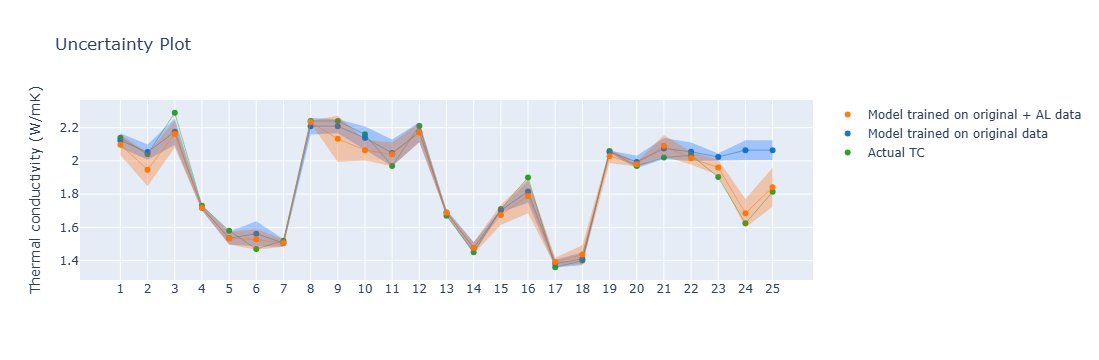

In [87]:
Uncertainty_plotly(df, Uncertainty_og_df, Uncertainty_AL_df)

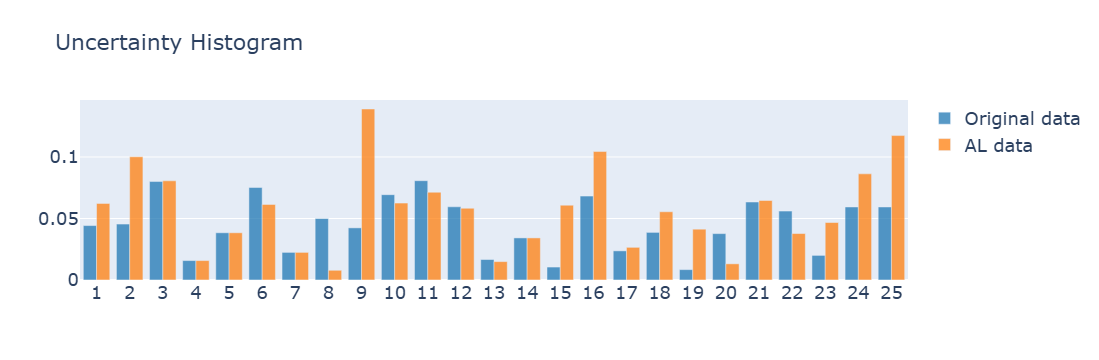

In [88]:
uncertainty_histogram_plotly(Uncertainty_og_df, Uncertainty_AL_df)

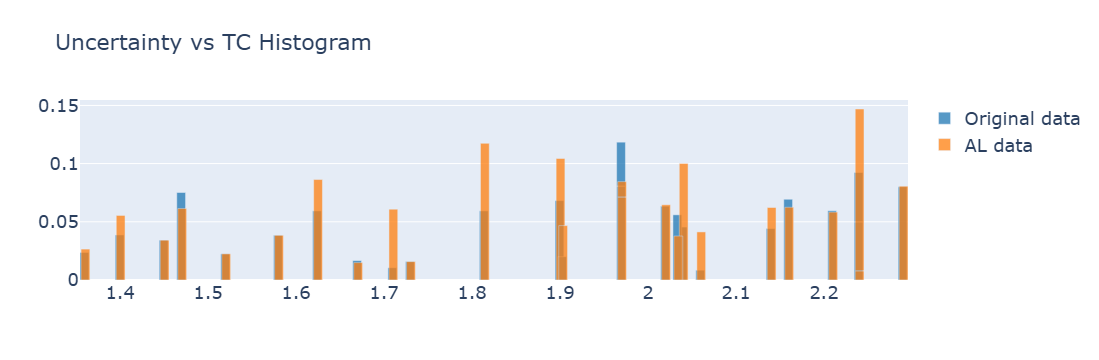

In [89]:
uncertainty_TC_histogram_plotly(Uncertainty_og_df, Uncertainty_AL_df, width=0.01)

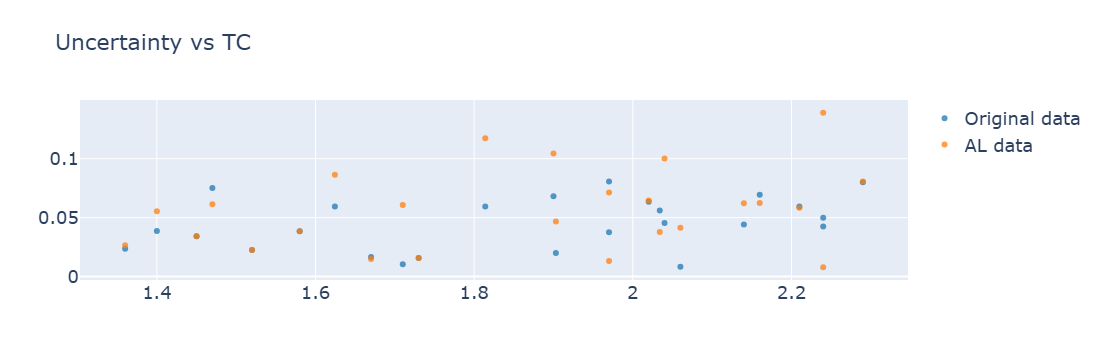

In [90]:
uncertainty_TC_scatter_plotly(Uncertainty_og_df, Uncertainty_AL_df)

In [91]:
print(maxUnc_og)
print(maxUnc_AL)

0.08072558763251571
0.13901779764095612


In [92]:
print(Uncertainty_og_df['Uncertainty'].mean())
print(Uncertainty_AL_df['Uncertainty'].mean())

0.04478939604355107
0.05695803191046769
